# Electricity emissions calculation based on DA RFNBO June 2022

The source data:
https://ec.europa.eu/eurostat/databrowser/view/NRG_BAL_C__custom_3055577/default/table?lang=en

Meta data on the used fuel categories:
https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_NOM_DTL&StrNom=CL_SIEC&StrLanguageCode=EN&IntPcKey=&StrLayoutCode=HIERARCHIC&IntCurrentPage=1

Useful explanation of the flows and their definition:
https://ec.europa.eu/eurostat/documents/38154/4956218/Energy-Balance-Formulas.xlsx/cc2f9ade-5c0b-47b5-b83d-c05fe86eef6c

# RFNBO definition of carbon intensity

The fuels used for gross electricity production in electricity only plants are determined based on the electricity production and the efficiency of conversion to electricity. In the case of Combined Heat and Power (CHP), the fuels used for heat produced in CHP shall be counted by considering alternative heat production with average overall efficiencies of 85%, while the rest shall be attributed to electricity generation.

For nuclear power plants, the conversion efficiency from nuclear heat shall be assumed to be 33% or data provided by Eurostat or a similar, accredited source.

No fuels are associated with electricity production from renewables that include hydro, solar, wind and geothermal. The emissions from the construction and decommissioning and waste management of electricity producing facilities are not considered. Thus, the carbon equivalent emissions associated with the renewable electricity (wind, solar, hydro and geothermal) production are considered to be equal to zero.
The CO2 equivalent emissions from gross electricity production should include upstream emissions from JEC WTW v5 (Prussi et all, 2020) listed in Table 3 and the default emission factors for stationary combustion from IPCC Guidelines for National Greenhouse Gas Inventories (IPCC 2006) listed in Tables 1 and 2. The upstream emissions for supplying the fuel used are the JEC WTW v5 upstream emission factors (Prussi et all, 2020).

The calculation of the carbon intensity of electricity shall be done following the formula:

𝑒𝑔𝑟𝑜𝑠𝑠_𝑝𝑟𝑜𝑑=Σ(𝑐𝑖−𝑢𝑝𝑠+𝑐𝑖−𝑐𝑜𝑚𝑏)∗𝐵𝑖

where: 

𝑒𝑔𝑟𝑜𝑠𝑠_𝑝𝑟𝑜𝑑 – CO2 equivalent emissions [𝑔𝐶𝑂2𝑒𝑞]

𝑐𝑖−𝑢𝑝𝑠 – upstream CO2 equivalent emission factors [𝑔𝐶𝑂2𝑒𝑞𝑀𝐽]

𝑐𝑖−𝑐𝑜𝑚𝑏 – CO2 equivalent emission factors from fuels combustion [𝑔𝐶𝑂2𝑒𝑞𝑀𝐽]

𝐵𝑖 – fuel consumption for electricity generation [𝑀𝐽]

𝑖=1⋯𝑘 –fuels used for electricity production

The amount of net electricity production is determined by the gross electricity production, own electricity consumption in the power plant and the electricity losses in pump storage.

𝐸𝑛𝑒𝑡=𝐸𝑔𝑟𝑜𝑠𝑠−𝐸𝑜𝑤𝑛−𝐸𝑝𝑢𝑚𝑝

where: 

𝐸𝑛𝑒𝑡 – net electricity production [𝑀𝐽]

𝐸𝑔𝑟𝑜𝑠𝑠 – gross electricity production [𝑀𝐽]

𝐸𝑜𝑤𝑛 – own internal electricity consumption in power plant [𝑀𝐽]

𝐸𝑝𝑢𝑚𝑝 – electricity for pumping [𝑀𝐽]

The carbon intensity of net produced electricity shall be the total gross GHG emitted for producing or using the net electricity:

𝐶𝐼=𝑒𝑔𝑟𝑜𝑠𝑠_𝑝𝑟𝑜𝑑/𝐸𝑛𝑒𝑡

Where: 𝐶𝐼 – CO2 equivalent emissions from electricity production [𝑔𝐶𝑂2𝑒𝑞𝑀𝐽]


/home/hurtiol/.local/lib/python3.8/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


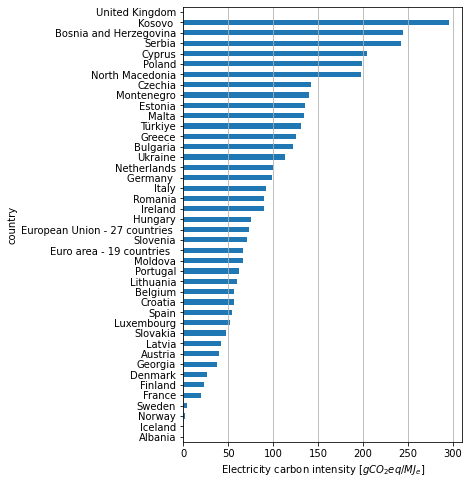

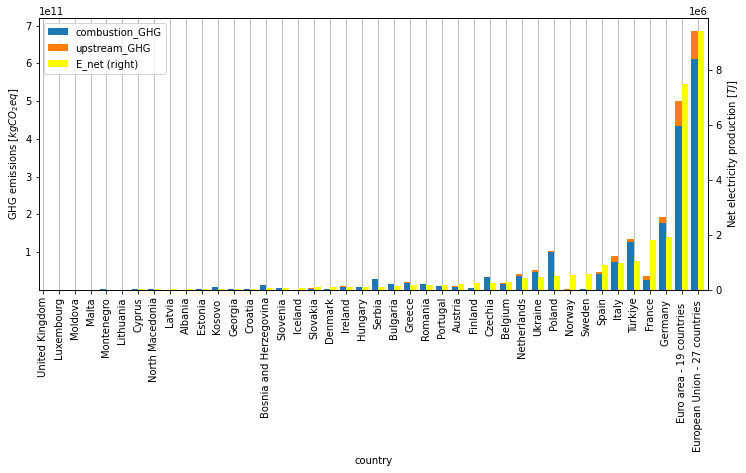

In [1]:
#!pip install pyjstat openpyxl
from pyjstat import pyjstat
import pandas as pd
from os.path import exists
from os import path
import requests
import re

class CarbonIntensityCalculator:
  def __init__(self, data_path = '.') -> None:
      self.GWP_factors = {
          'CO2': 1,
          'CH4': 25,
          'N2O': 298
      }
      self.data_path = data_path
      fuels = pd.read_csv(data_path+'/emission_factors_energy_products.csv', skiprows=[0])
      combustion_columns = [col for col in fuels.columns if col.startswith('ef')]
      fuels['efCombustion'] = (fuels[combustion_columns] * [self.GWP_factors[x[-3:]] for x in combustion_columns]).sum(axis=1)
      self.fuels = fuels
      self.raw = None
      self.geo_list = None
      self.carbon_intensity = None

  def save_single_df(self, dataset) -> None:
    df = dataset.write('dataframe', naming='id')
    # here we don't care about None, as 0 fuels use has 0 impact
    df['value'].fillna(0, inplace=True)
    if self.raw is None:
      self.geo_list = df['geo'].unique()
      self.raw = df
    else:
      self.raw = pd.concat([self.raw, df], ignore_index=True)

  def load_raw(self, from_api=False, year=2020) -> None:
    fuel_list = {}
    for fuel in self.fuels.itertuples(index=False):
      fuel_list[fuel.siec] = dict(fuel._asdict())
      if from_api:
        dataset = self.load_raw_from_eurostat_api(fuel, year=2020)
      else:
        dataset = self.load_raw_from_files(fuel)
      self.save_single_df(dataset)
    self.raw = self.raw.pivot_table(values='value', index=['siec', 'geo', 'time'], columns='nrg_bal', aggfunc='first')
    self.raw = self.raw.join(pd.DataFrame(fuel_list).transpose().set_index('siec'))
    self.raw.sort_index(inplace=True)
  
  def load_raw_from_files(self, fuel) -> pyjstat.Dataset:
    if(exists(path.join(self.data_path + f"/stats/{fuel.siec}_jsonstat.json"))):
      with open(path.join(self.data_path + f"/stats/{fuel.siec}_jsonstat.json")) as f:
        dataset = pyjstat.Dataset.read(f)
      self.save_single_df(dataset)
      return dataset
    else:
      print("file not found: " + self.data_path + f"/stats/{fuel.siec}_jsonstat.json")

  def load_raw_from_eurostat_api(self, fuel, year) -> pyjstat.Dataset:
    url = f"http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/nrg_bal_c?siec={fuel.siec}&time={year}&precision=1&unit=TJ&nrg_bal=GHP_APCHP&nrg_bal=GHP_MAPCHP&nrg_bal=TI_EHG_APCHP_E&nrg_bal=TI_EHG_APE_E&nrg_bal=TI_EHG_MAPCHP_E&nrg_bal=TI_EHG_MAPE_E&nrg_bal=TI_EHG_EPS&nrg_bal=TO_EHG_PH&nrg_bal=NRG_EHG_E&nrg_bal=GEP"
    dataset = pyjstat.Dataset.read(url)
    
    with open(path.join(self.data_path + f"/stats/{fuel.siec}_jsonstat.json"), 'w') as file:
      file.write(dataset.write())
    return dataset

  def calculate_Bi(self) -> None:
    self.raw['fuel_for_elec_in_CHP'] = (self.raw['TI_EHG_MAPCHP_E'] + self.raw['TI_EHG_APCHP_E']) - ((self.raw['GHP_MAPCHP'] + self.raw['GHP_APCHP']) / 0.85)
    self.raw['Bi'] = self.raw['TI_EHG_MAPE_E'] + self.raw['TI_EHG_APE_E'] + self.raw['fuel_for_elec_in_CHP']

  def calculate_emissions(self) -> None:
    self.raw['upstream_GHG'] = self.raw['Bi'] * self.raw['UpstreamE3']
    self.raw['combustion_GHG'] = self.raw['Bi'] * self.raw['efCombustion']
    self.raw['total_GHG'] = self.raw['upstream_GHG'] + self.raw['combustion_GHG']

  def calculate_electricity(self) -> None:
    self.raw['E_pump'] = self.raw['TI_EHG_EPS'] #- self.raw['TO_EHG_PH'] TO_EHG_PH already in TO (and GEP)
    #self.raw['E_own'] = self.raw['NRG_EHG_E']
    #self.raw['E_gross'] = self.raw['GEP']
    self.raw['E_net'] = self.raw['GEP'] - self.raw['NRG_EHG_E'] - self.raw['E_pump']

  def calculate_carbon_intensity(self) -> None:
    self.carbon_intensity = self.raw[['GEP', 'E_pump', 'E_net']].filter(regex= 'TOTAL', axis=0)
    self.carbon_intensity = self.carbon_intensity.droplevel('siec')
    emissions = self.raw[self.raw.index.get_level_values('siec') != 'TOTAL'][['upstream_GHG', 'combustion_GHG', 'total_GHG']].groupby('geo').sum()
    self.carbon_intensity = self.carbon_intensity.join(emissions)
    # units are kg_CO2e and TJ, resulting unit is g_CO2e/MJ
    self.carbon_intensity['Ci'] = self.carbon_intensity['total_GHG'] / self.carbon_intensity['E_net'] / 1000

  def get_country_names(self):    
    rep = requests.get("https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/codelist/ESTAT/GEO?format=JSON&lang=en").json()
    self.countries = rep["category"]["label"]    
    self.carbon_intensity['country'] = self.carbon_intensity.index.get_level_values('geo').map(self.get_country_name)

  def get_country_name(self, code):
    return re.sub("[\(\[].*?[\)\]]", "", self.countries[code])

  def to_excel(self, filename='result.xlsx') -> None:

    with pd.ExcelWriter(filename) as writer:
      self.raw.to_excel(writer, merge_cells=False, sheet_name='raw')
      self.carbon_intensity.to_excel(writer, merge_cells=False, sheet_name='carbon_intensity')

  def chart(self):
    # as an idea to print some nice charts
    fig = self.carbon_intensity.sort_values("Ci").plot(kind="barh", x="country", y="Ci", legend=False, figsize=(5,8))
    fig.set_xlabel("Electricity carbon intensity [$g CO_2eq/MJ_e$]")
    fig.xaxis.grid(True, which='major')

    fig2 = self.carbon_intensity.sort_values("E_net").plot(kind="bar", x="country", y=["combustion_GHG", "upstream_GHG"], stacked=True, width=0.4, position=1, figsize=(12,5))
    self.carbon_intensity.sort_values("E_net").plot(kind="bar", x="country", y="E_net", width=0.4, position=0,  color="yellow", secondary_y=True, ax=fig2)
    fig2.set_ylabel("GHG emissions [$kg CO_2eq$]")
    fig2.right_ax.set_ylabel("Net electricity production [$TJ$]")
    fig2.xaxis.grid(True, which='major')

  def run(self, from_api=False, year=2020):
    self.load_raw(from_api, year)
    self.calculate_Bi()
    self.calculate_emissions()
    self.calculate_electricity()
    self.calculate_carbon_intensity()
    self.get_country_names()
    self.to_excel()

cic = CarbonIntensityCalculator()
cic.run(from_api=True, year=2020)
cic.chart()

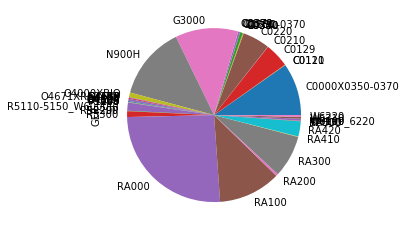

In [30]:
cic.raw.query("geo.str.len()<3 and siec != 'TOTAL'",engine='python').GEP.groupby(by="siec").sum().plot(kind="pie")

In [2]:
cic.carbon_intensity

,,GEP,E_pump,E_net,upstream_GHG,combustion_GHG,total_GHG,Ci,country
geo,time,,,,,,,,
AL,2020,1.912740e+04,0.000,19035.044,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,Albania
AT,2020,2.611665e+05,17324.442,233168.418,1.060270e+09,8.157166e+09,9.217436e+09,39.531237,Austria
BA,2020,6.074640e+04,406.800,55792.866,2.398588e+08,1.340747e+10,1.364732e+10,244.606985,Bosnia and Herzegovina
BE,2020,3.202459e+05,5025.240,301705.922,2.717529e+09,1.451395e+10,1.723148e+10,57.113496,Belgium
BG,2020,1.465881e+05,2593.462,128296.611,6.852141e+08,1.500900e+10,1.569422e+10,122.327598,Bulgaria
CY,2020,1.745710e+04,0.000,16736.031,4.242932e+08,2.998874e+09,3.423167e+09,204.538747,Cyprus
CZ,2020,2.932192e+05,6021.410,245635.227,1.871069e+09,3.316206e+10,3.503313e+10,142.622563,Czechia
DE,2020,2.065738e+06,31939.200,1933718.400,1.524432e+10,1.768083e+11,1.920527e+11,99.317804,Germany
DK,2020,1.034232e+05,0.000,99656.553,1.880426e+08,2.516788e+09,2.704831e+09,27.141524,Denmark
